Collatz beta notebook

In [9]:
"""
This notebook analyses the betas of collatz sequences and their relationship
to other components. The beta  of an odd collatz number is defined by the 
following equation: beta = 1 + 1/k*x where x is the odd number. 
"""

# Imports
import random as rnd
import matplotlib.pyplot as plt
from math import log2
import pandas as pd
from collatz import commons as com
from collatz import generator as gen
from collatz import cycles


# Helper functions
def _predict_alpha(k_factor, cycle_lengths):
    result_list = []
    for i in cycle_lengths:
        result_list.append(cycles.predict_cycle_alpha(k_factor, i))
    return result_list


# Configuration
k = 3
max_value = 1001
max_iterations = 500
start_value = rnd.randint(1, max_value)

if start_value % 2 == 0:
    start_value = start_value + 1

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 10000)
pd.set_option('display.expand_frame_repr', False)

# Create a collatz sequence and analyse it
analysis_frame = gen.generate_odd_collatz_sequence(
    start_value=start_value, k=k, max_iterations=max_iterations)

# Filter odd values
analysis_frame = analysis_frame[analysis_frame["odd"] == 1]
analysis_frame = analysis_frame.reset_index(drop=True)

# Derive additional fields
analysis_frame["i"] = analysis_frame.index + 1
analysis_frame["log_k^i"] = log2(k)*analysis_frame["i"]

# Calculate alpha
analysis_frame["alpha"] = analysis_frame["next_collatz"].apply(com.trailing_zeros)
analysis_frame["alpha"] = analysis_frame["alpha"].astype("int64")
analysis_frame["alpha_sum"] = analysis_frame["alpha"].cumsum()
analysis_frame["alpha_pred"] = _predict_alpha(k, analysis_frame['i'])
analysis_frame["alpha_diff"] = analysis_frame["alpha_pred"] - analysis_frame["alpha_sum"]
analysis_frame["next_alpha_pred"] = _predict_alpha(k, analysis_frame['i'])

# Calculate beta
analysis_frame["beta"] = 1 + 1/(k*analysis_frame["collatz"])
analysis_frame["beta_prod"] = analysis_frame["beta"].cumprod()
analysis_frame["beta_log"] = analysis_frame["beta"].apply(log2)
analysis_frame["beta_prod_log"] = analysis_frame["beta_prod"].apply(log2)

analysis_frame["beta_prod_hyp"] = \
    analysis_frame["alpha_pred"] - analysis_frame["log_k^i"]  \
    + analysis_frame["alpha_diff"]

analysis_frame["beta_prod_diff"] = \
    analysis_frame["beta_prod_hyp"] - analysis_frame["beta_prod_log"]
analysis_frame["beta_prod_diff"] = analysis_frame["beta_prod_diff"].round(4)

# Get max and min values
max_beta_prod_log = round(analysis_frame["beta_prod_log"].max(), 4)
beta_diff =  analysis_frame[analysis_frame["beta_prod_diff"] >= 0]["beta_prod_diff"]
min_beta_diff = None
min_i = None

if len(beta_diff) > 0:
    min_beta_diff = beta_diff.min()
    min_i = beta_diff.idxmin() + 1

# Print results
print_frame = analysis_frame[[
    "i", "collatz", "log_k^i", "alpha_sum", "alpha_pred", "alpha_diff",
    "beta_prod_log", "beta_prod_hyp", "beta_prod_diff"]]

print_frame.columns = ["i","xi", "k^i", "a", "a_pred", "a_diff",
                       "b_prod", "b_prod_hyp", "b_prod_diff"]

print("x1:", start_value, " K:", k, 
      " Max(b_prod):", max_beta_prod_log, 
      " Min(b_prod_diff):", min_beta_diff,
      " i:", min_i,
      "\n")

print(print_frame.to_string(index=False), "\n")

x1: 435  K: 3  Max(b_prod): 0.5554  Min(b_prod_diff): 0.8282  i: 2 

 i   xi        k^i   a  a_pred  a_diff    b_prod  b_prod_hyp  b_prod_diff
 1  435   1.584963   1       2       1  0.001105    1.415037       1.4139
 2  653   3.169925   4       4       0  0.001841    0.830075       0.8282
 3  245   4.754888   9       5      -4  0.003803   -3.754888      -3.7587
 4   23   6.339850  10       7      -3  0.024561   -2.339850      -2.3644
 5   35   7.924813  11       8      -3  0.038236   -2.924813      -2.9630
 6   53   9.509775  16      10      -6  0.047281   -5.509775      -5.5571
 7    5  11.094738  20      12      -8  0.140391   -7.094738      -7.2351
 8    1  12.679700  22      13      -9  0.555428   -8.679700      -9.2351 



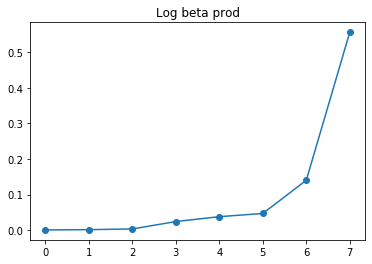

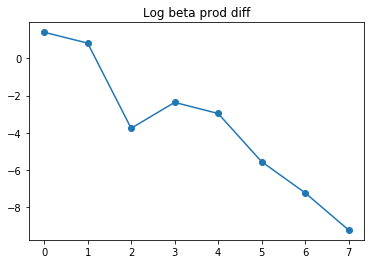

In [10]:
# Plot results
plt.figure()
plt.title("Log beta prod")
plt.plot(analysis_frame["beta_prod_log"], "-o", label='log beta prod')

plt.figure()
plt.title("Log beta prod diff")
plt.plot(analysis_frame["beta_prod_diff"], "-o", label='diff')

plt.show()